In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumCircuit
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from src.networks import create_ring_graph, create_star_graph, get_graph_properties
from src.classical_walk import run_classical_simulation
from src.quantum_walk import run_quantum_simulation
from src.metrics import analyze_distribution_history, compare_walks, generate_summary_statistics
from src.visualizations import (
    plot_network, plot_probability_bars, animate_diffusion,
    plot_metrics_over_time, create_heatmap_comparison,
    create_summary_figure, quick_comparison
)

np.random.seed(42)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10



Network: Ring Graph (n=16)
Nodes: 16
Edges: 16
Average Degree: 2.00
Diameter: 8


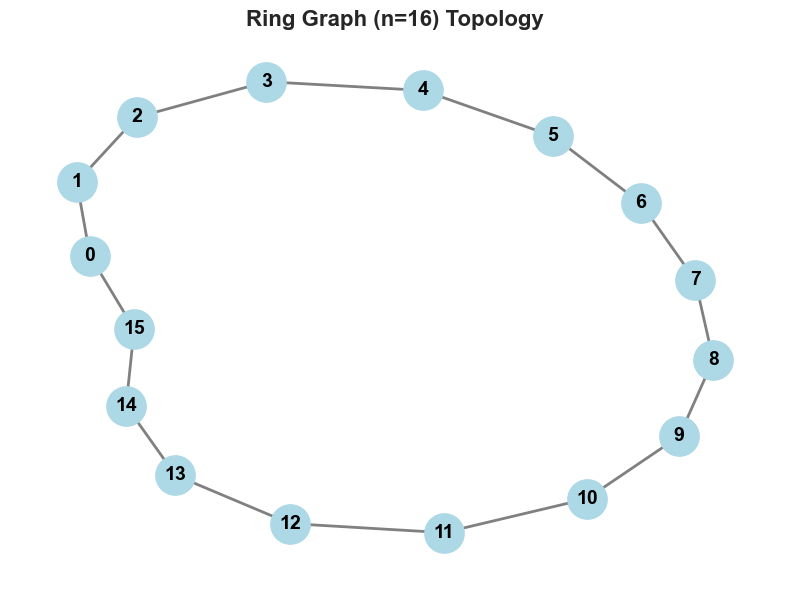

In [2]:
# 16-Node Ring Graph

num_nodes = 16
G = create_ring_graph(num_nodes)

props = get_graph_properties(G)
print(f"\nNetwork: {G.name}")
print(f"Nodes: {props['num_nodes']}")
print(f"Edges: {props['num_edges']}")
print(f"Average Degree: {props['avg_degree']:.2f}")
print(f"Diameter: {props['diameter']}")

fig, ax = plt.subplots(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue',
        node_size=800, font_size=14, font_weight='bold',
        edge_color='gray', width=2)
ax.set_title(f'{G.name} Topology', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

  Final max probability: 0.1766 at node 0
  Final entropy: 2.9379
  Final coverage: 50.00%


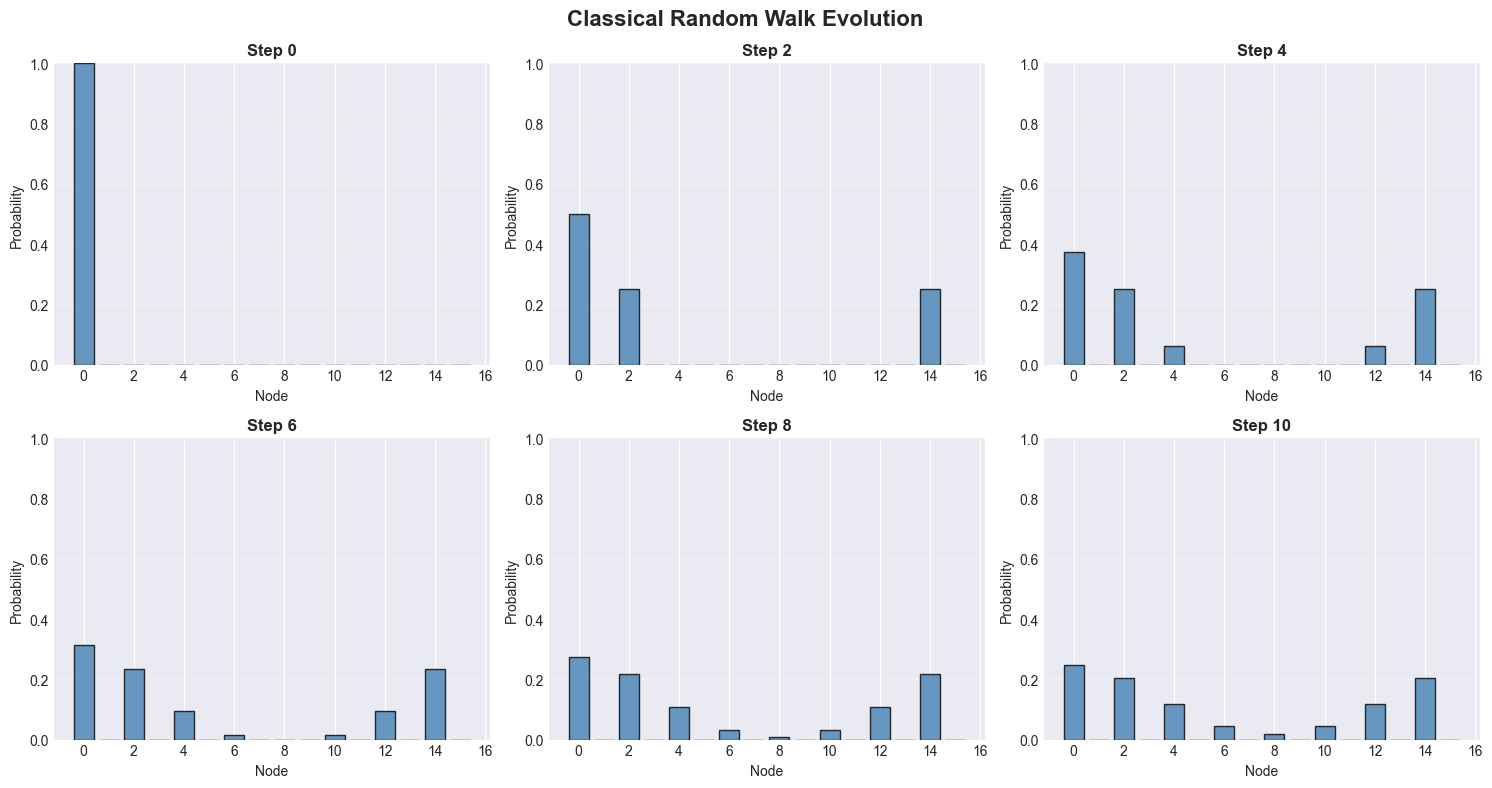

In [ ]:
# Classical Baseline

num_steps = 20
start_node = 0

classical_history, classical_meta = run_classical_simulation(
    G, steps=num_steps, start_node=start_node
)

classical_metrics = analyze_distribution_history(classical_history)

print(f"  Final max probability: {classical_meta['final_distribution'].max():.4f} at node {classical_meta['max_probability_node']}")
print(f"  Final entropy: {classical_metrics['entropy'][-1]:.4f}")
print(f"  Final coverage: {classical_metrics['coverage'][-1]:.2%}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, step in enumerate([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20][:6]):
    ax = axes[i]
    probs = classical_history[step]
    ax.bar(range(num_nodes), probs, color='steelblue', alpha=0.8, edgecolor='black')
    ax.set_title(f'Step {step}', fontweight='bold')
    ax.set_xlabel('Node')
    ax.set_ylabel('Probability')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Classical Random Walk Evolution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

  Circuit qubits: 5
  Circuit depth: 221
  Final max probability: 0.3966 at node 2
  Final entropy: 2.5671
  Final coverage: 43.75%


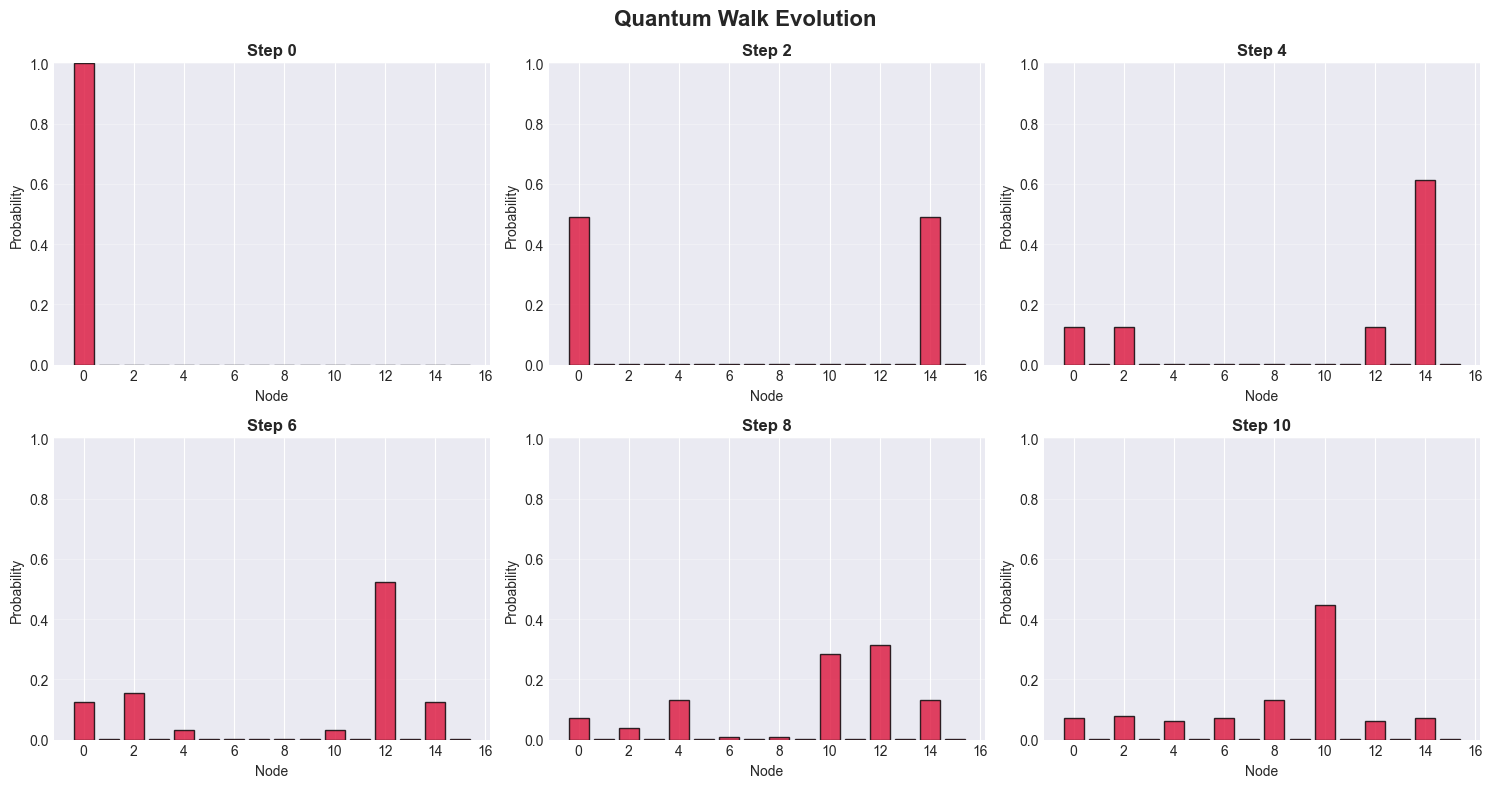

In [4]:
# Quantum Walk Implementation

quantum_history, quantum_circuit, quantum_meta = run_quantum_simulation(
    num_nodes=num_nodes,
    steps=num_steps,
    start_position=start_node,
    coin_bias=np.pi/4
)

quantum_metrics = analyze_distribution_history(quantum_history)

print(f"  Circuit qubits: {quantum_meta['num_qubits']}")
print(f"  Circuit depth: {quantum_meta['circuit_depth']}")
print(f"  Final max probability: {quantum_meta['final_distribution'].max():.4f} at node {quantum_meta['max_probability_node']}")
print(f"  Final entropy: {quantum_metrics['entropy'][-1]:.4f}")
print(f"  Final coverage: {quantum_metrics['coverage'][-1]:.2%}")


fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, step in enumerate([0, 2, 4, 6, 8, 10]):
    ax = axes[i]
    probs = quantum_history[step]
    ax.bar(range(num_nodes), probs, color='crimson', alpha=0.8, edgecolor='black')
    ax.set_title(f'Step {step}', fontweight='bold')
    ax.set_xlabel('Node')
    ax.set_ylabel('Probability')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Quantum Walk Evolution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Animation saved to ../outputs/animations/ring_diffusion.gif


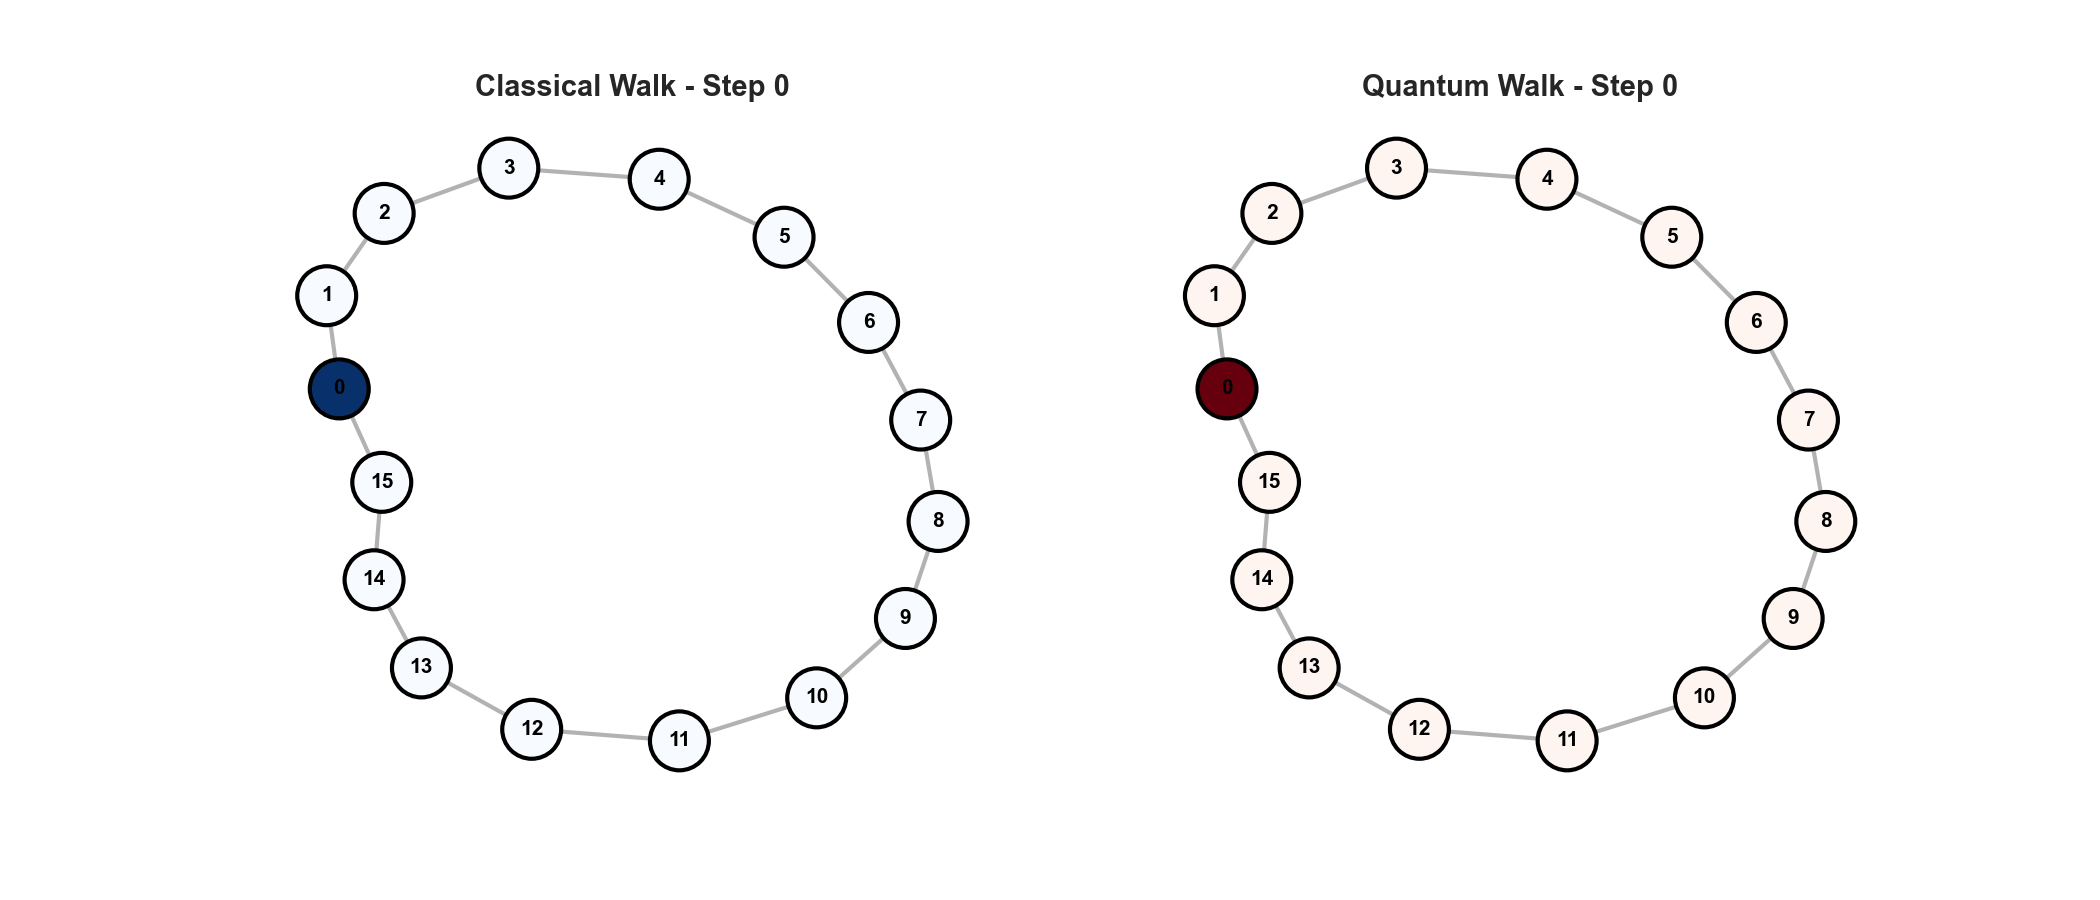

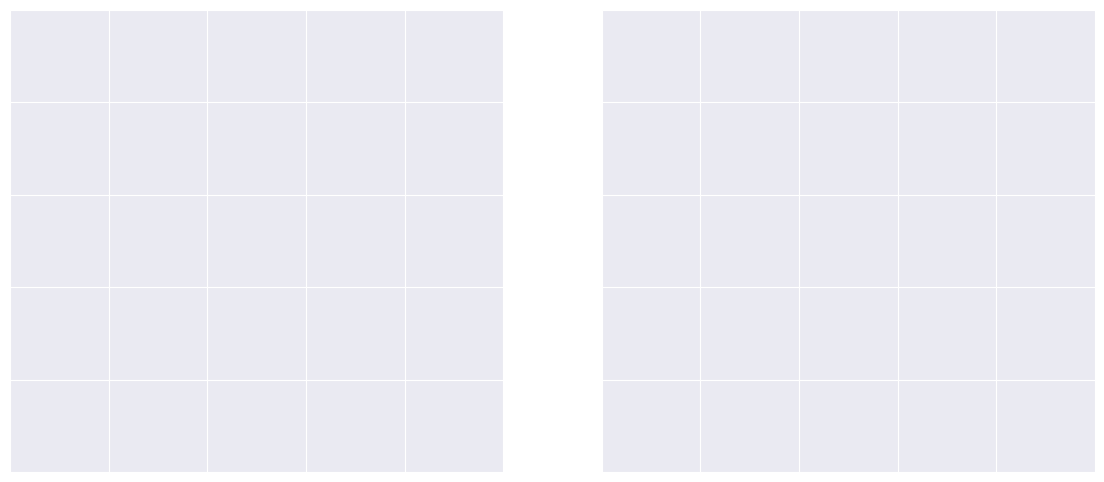

In [5]:
# Animations

import os
from IPython.display import Image

os.makedirs("../outputs/animations", exist_ok=True)

anim = animate_diffusion(
    classical_history,
    quantum_history,
    G,
    filename="../outputs/animations/ring_diffusion.gif",
    interval=600
)

Image(filename="../outputs/animations/ring_diffusion.gif")

Quantum Walk Circuit (first 3 steps):
Total qubits: 5
Circuit depth: 34
Gate count: 63


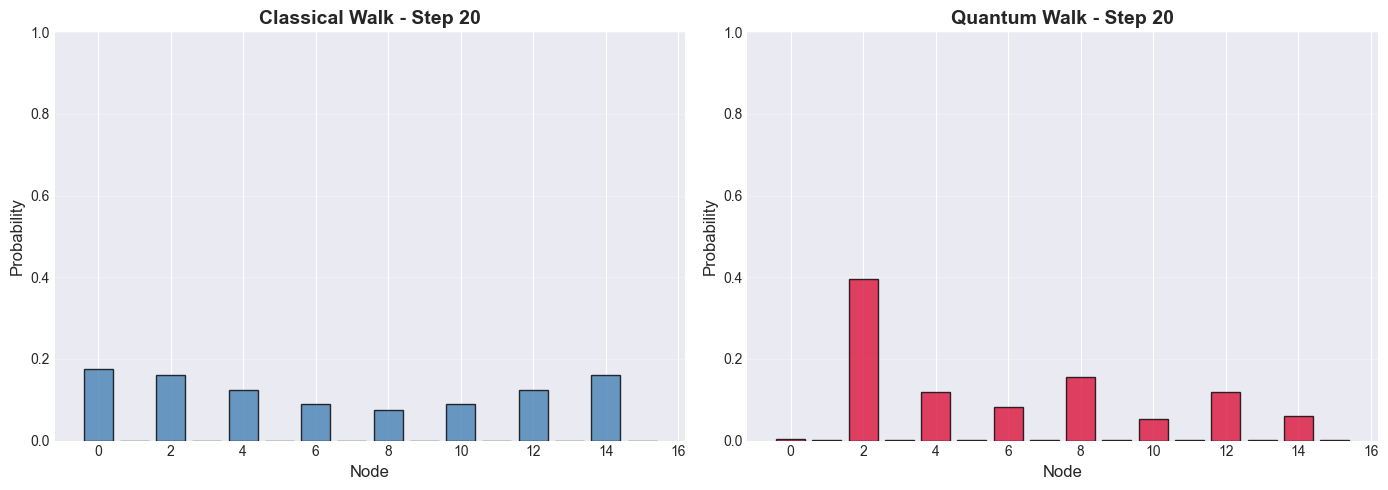

In [6]:
# Distribution

small_circuit, _ = run_quantum_simulation(num_nodes=16, steps=3, coin_bias=np.pi/4)[1:3]
print("Quantum Walk Circuit (first 3 steps):")
print(f"Total qubits: {small_circuit.num_qubits}")
print(f"Circuit depth: {small_circuit.depth()}")
print(f"Gate count: {len(small_circuit.data)}")

fig = plot_probability_bars(
    classical_history[-1],
    quantum_history[-1],
    step=num_steps
)
plt.show()


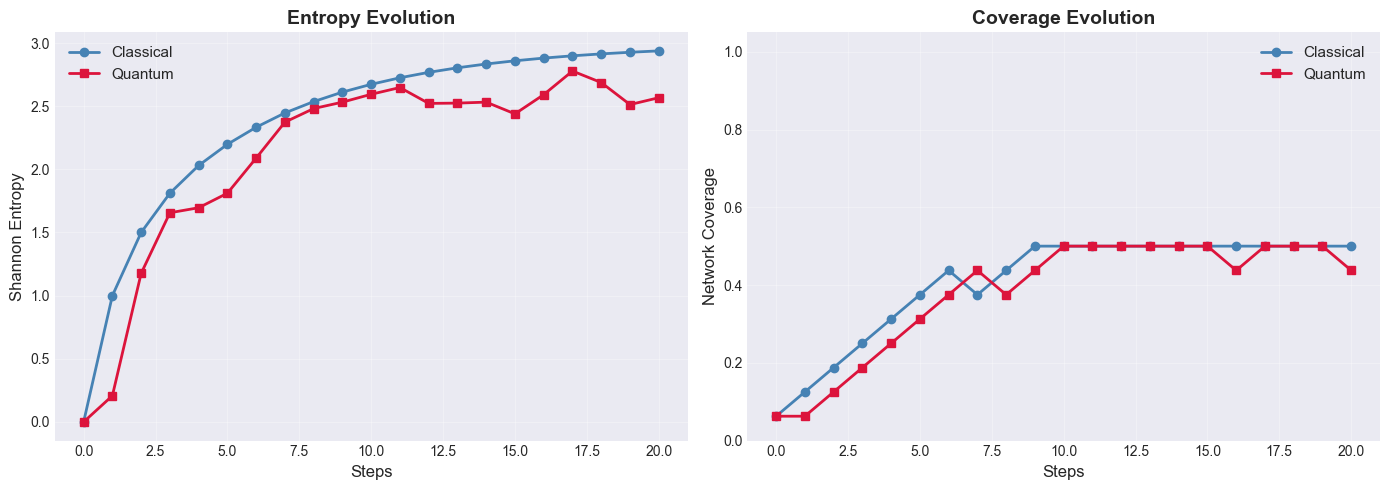

Quantum vs Classical

Coverage rates similar

Final entropy difference: -0.371

Total variation distance: 0.328


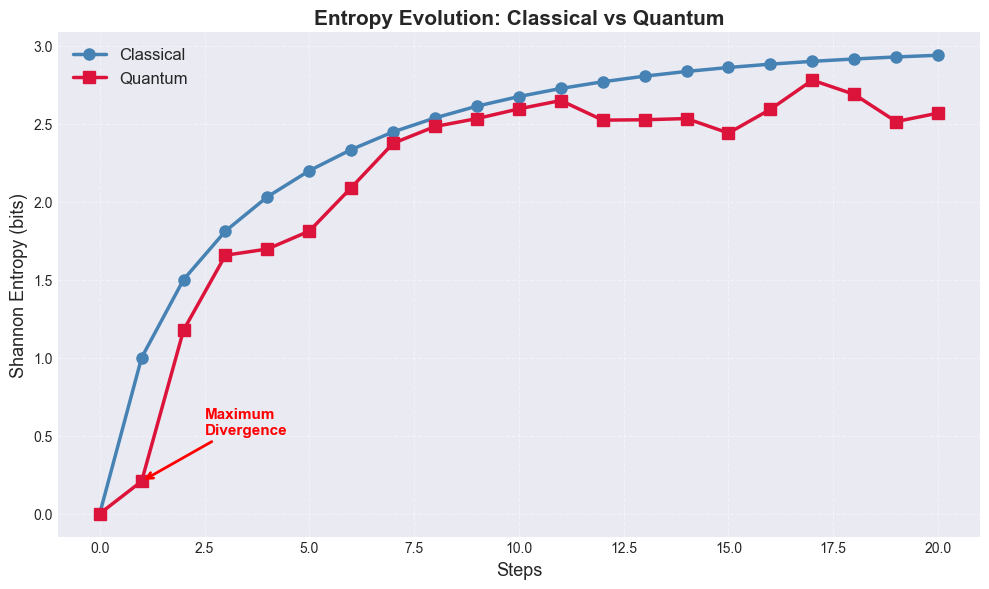


 Entropy Statistics:
  Classical final entropy: 2.9379
  Quantum final entropy: 2.5671
  Difference: -0.3708


In [ ]:
# Metrics

comparison = compare_walks(classical_history, quantum_history)
fig = plot_metrics_over_time(classical_metrics, quantum_metrics)
plt.show()

summary = generate_summary_statistics(comparison)
print(summary)

fig, ax = plt.subplots(figsize=(10, 6))

steps = range(len(classical_metrics['entropy']))
ax.plot(steps, classical_metrics['entropy'],
        'o-', linewidth=2.5, markersize=8, label='Classical', color='steelblue')
ax.plot(steps, quantum_metrics['entropy'],
        's-', linewidth=2.5, markersize=8, label='Quantum', color='crimson')

ax.set_xlabel('Steps', fontsize=13)
ax.set_ylabel('Shannon Entropy (bits)', fontsize=13)
ax.set_title('Entropy Evolution: Classical vs Quantum', fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.4, linestyle='--')

max_diff_step = np.argmax(np.abs(
    np.array(quantum_metrics['entropy']) - np.array(classical_metrics['entropy'])
))
ax.annotate('Maximum\nDivergence',
            xy=(max_diff_step, quantum_metrics['entropy'][max_diff_step]),
            xytext=(max_diff_step+1.5, quantum_metrics['entropy'][max_diff_step]+0.3),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print(f"\n Entropy Statistics:")
print(f"  Classical final entropy: {classical_metrics['entropy'][-1]:.4f}")
print(f"  Quantum final entropy: {quantum_metrics['entropy'][-1]:.4f}")
print(f"  Difference: {quantum_metrics['entropy'][-1] - classical_metrics['entropy'][-1]:.4f}")

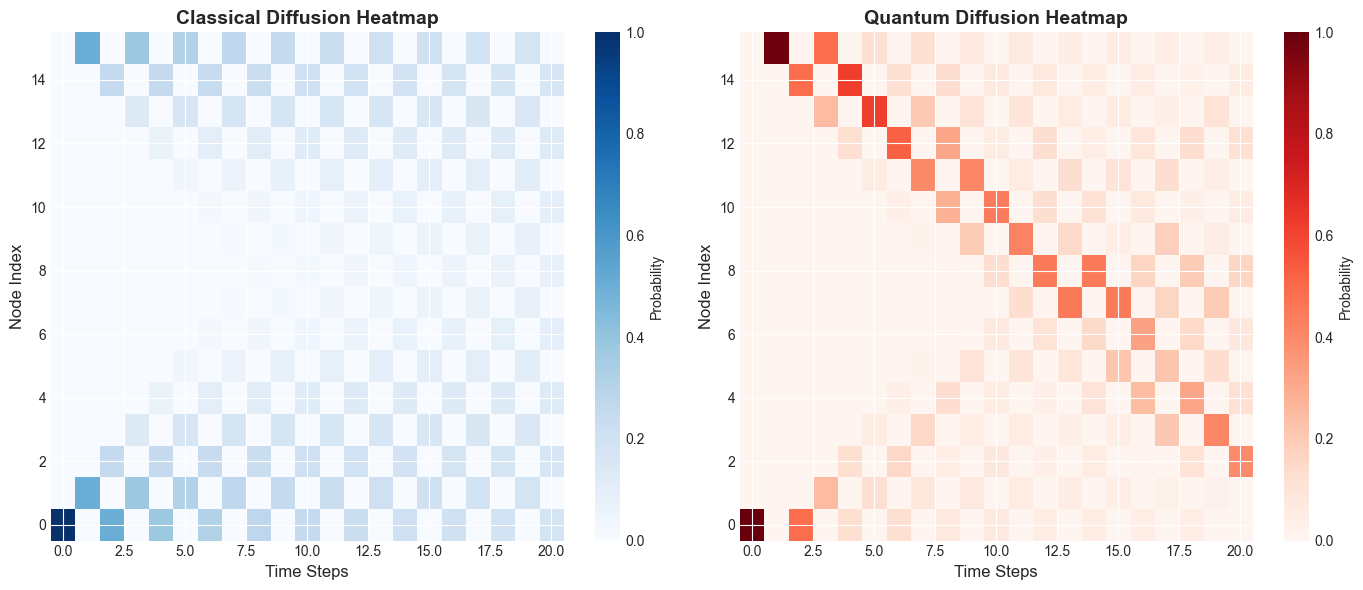

In [8]:
# Heatmap

fig = create_heatmap_comparison(classical_history, quantum_history)
plt.show()


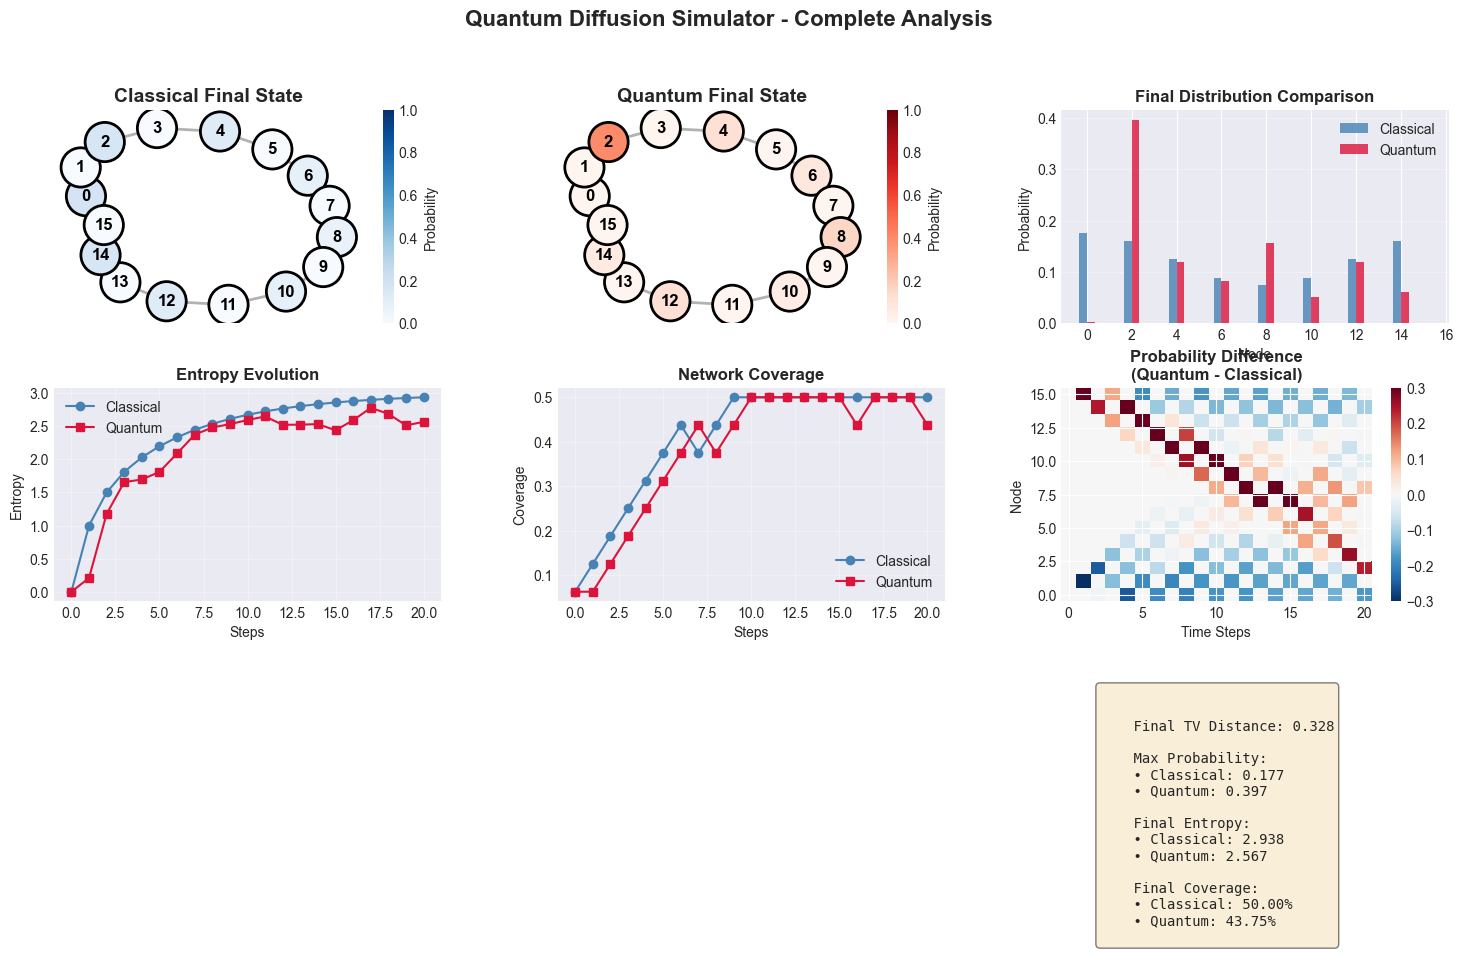

In [9]:
# Summary Figure

fig = create_summary_figure(
    classical_history,
    quantum_history,
    G,
    classical_metrics,
    quantum_metrics,
)

plt.savefig('./outputs/figures/summary_figure.png', dpi=200, bbox_inches='tight')
plt.show()

In [10]:
import numpy as np

def ring_distance_std(prob_distribution: np.ndarray, start_node: int = 0) -> float:
    n = len(prob_distribution)
    indices = np.arange(n)
    
    diff = np.abs(indices - start_node)
    dist = np.minimum(diff, n - diff)  # circular distance
    
    mean_dist = np.sum(prob_distribution * dist)
    var_dist = np.sum(prob_distribution * (dist - mean_dist) ** 2)
    return np.sqrt(var_dist)

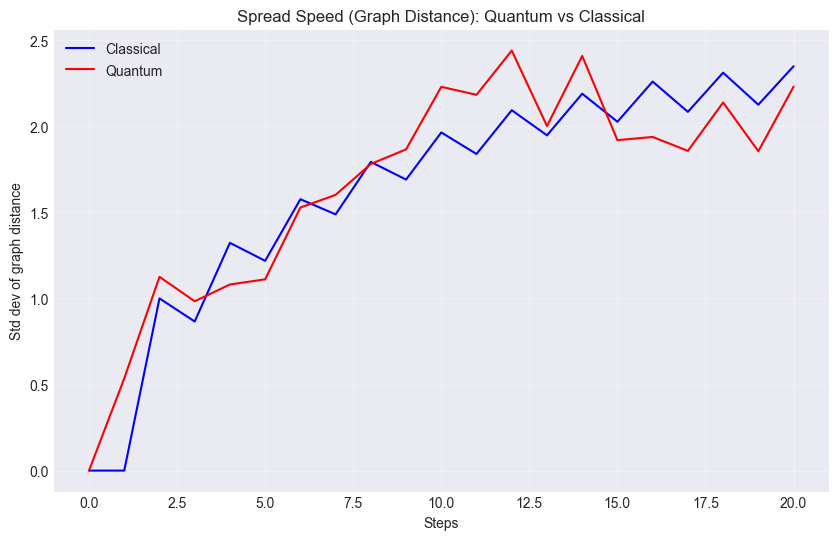

In [11]:
start_node = 0

classical_spread = [
    ring_distance_std(p, start_node) for p in classical_history
]
quantum_spread = [
    ring_distance_std(p, start_node) for p in quantum_history
]

fig, ax = plt.subplots(figsize=(10, 6))
steps = range(len(classical_spread))
ax.plot(steps, classical_spread, 'b-', label='Classical')
ax.plot(steps, quantum_spread, 'r-', label='Quantum')
ax.set_xlabel('Steps')
ax.set_ylabel('Std dev of graph distance')
ax.set_title('Spread Speed (Graph Distance): Quantum vs Classical')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
